In [38]:
# Movie Genre Classification Neural Network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
#data_path = '../feature_engineering/data_with_new_features_v2.csv'
data_path = "../data_cleaning/data/imputed_data.csv" 
df = pd.read_csv(data_path)

print("Available columns for splitting:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")

# Check unique values in potential split columns
if 'participant' in df.columns:
    print(f"\nParticipant values: {sorted(df['participant'].unique())}")
    print(f"Participant counts: {df['participant'].value_counts().to_dict()}")

# Preprocessing - Exclude split column from features to avoid data leakage
feature_columns = [col for col in df.columns if col not in ['timestamp', 'participant', 'genre', 'person']]
X = df[feature_columns].copy()
y = df['genre'].copy()

print(f"Excluded columns: ['timestamp', 'participant', 'genre', 'person']")
print(f"Feature columns: {feature_columns}")

# Encode non-numeric columns
non_numeric_cols = [col for col in X.columns if X[col].dtype == 'object']
if non_numeric_cols:
    for col in non_numeric_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

# Column-based train-test split (person-based)
# Training: clara, kenji | Test: aimen
SPLIT_COLUMN = 'participant'
TRAIN_VALUES = ['aimen', 'kenji']  # Training data
TEST_VALUES = ['clara']            # Test data

if SPLIT_COLUMN in df.columns:
    print(f"\nSplitting based on column: '{SPLIT_COLUMN}'")
    print(f"Training set will contain: {TRAIN_VALUES}")
    print(f"Test set will contain: {TEST_VALUES}")
    
    # Create boolean masks for train/test split
    train_mask = df[SPLIT_COLUMN].isin(TRAIN_VALUES)
    test_mask = df[SPLIT_COLUMN].isin(TEST_VALUES)
    
    # Split the data
    X_train = X[train_mask].copy()
    X_test = X[test_mask].copy()
    y_train = y_categorical[train_mask]
    y_test = y_categorical[test_mask]
    
    print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    
    # Check class distribution in splits
    train_classes = np.argmax(y_train, axis=1)
    test_classes = np.argmax(y_test, axis=1)
    
    print(f"\nTraining set class distribution:")
    for i, class_name in enumerate(label_encoder.classes_):
        count = np.sum(train_classes == i)
        print(f"  {class_name}: {count} ({count/len(train_classes)*100:.1f}%)")
    
    print(f"\nTest set class distribution:")
    for i, class_name in enumerate(label_encoder.classes_):
        count = np.sum(test_classes == i)
        print(f"  {class_name}: {count} ({count/len(test_classes)*100:.1f}%)")
        
else:
    print(f"Column '{SPLIT_COLUMN}' not found. Using random split instead.")
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

# Feature Selection - Reduce from 128 to manageable number
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

print(f"Original features: {X.shape[1]}")
print(f"Samples: {X.shape[0]} (Ratio: {X.shape[0]/X.shape[1]:.1f} samples per feature)")

# Feature selection on training data only (to avoid data leakage)
selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train, np.argmax(y_train, axis=1))
X_test_selected = selector.transform(X_test)

# Scale selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print(f"Selected features: {X_train_scaled.shape[1]}")
print(f"New ratio: {X_train_scaled.shape[0]/X_train_scaled.shape[1]:.1f} samples per feature")
print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

# Show feature importance scores
feature_scores = selector.scores_
selected_indices = selector.get_support(indices=True)
print(f"Top 5 feature scores: {sorted(feature_scores[selected_indices], reverse=True)[:5]}")


Available columns for splitting:
['timestamp', 'heart_rate', 'x_coordinate', 'y_coordinate', 'pupil_diameter_mm', 'iris_diameter_mm', 'pupil_iris_ratio', 'genre', 'person']

Dataset shape: (9356, 9)
Excluded columns: ['timestamp', 'participant', 'genre', 'person']
Feature columns: ['heart_rate', 'x_coordinate', 'y_coordinate', 'pupil_diameter_mm', 'iris_diameter_mm', 'pupil_iris_ratio']
Column 'participant' not found. Using random split instead.
Original features: 6
Samples: 9356 (Ratio: 1559.3 samples per feature)
Selected features: 5
New ratio: 1496.8 samples per feature
Training set: (7484, 5), Test set: (1872, 5)
Top 5 feature scores: [685.7052215010024, 89.28206713228634, 57.35512077786526, 57.35512077786391, 51.72227063389761]


In [39]:
# Smaller Neural Network Model (appropriate for reduced features)
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], kernel_regularizer=l1_l2(l2=1e-3)),
    LeakyReLU(alpha=0.0005),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, kernel_regularizer=l1_l2(l2=1e-3)),
    LeakyReLU(alpha=0.0005),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(3, activation='softmax')
])

# Compile and train
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)

print(f"Model Parameters: {model.count_params():,}")
print(f"Training completed in {len(history.history['loss'])} epochs")


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5491 - loss: 1.0233 - precision: 0.6033 - recall: 0.4530 - val_accuracy: 0.8363 - val_loss: 0.6317 - val_precision: 0.9230 - val_recall: 0.7528
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.7483 - loss: 0.6527 - precision: 0.7851 - recall: 0.6957 - val_accuracy: 0.8497 - val_loss: 0.4291 - val_precision: 0.8857 - val_recall: 0.8023
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7877 - loss: 0.5518 - precision: 0.8189 - recall: 0.7564 - val_accuracy: 0.8744 - val_loss: 0.3619 - val_precision: 0.8978 - val_recall: 0.8390
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.8195 - loss: 0.4931 - precision: 0.8432 - recall: 0.7892 - val_accuracy: 0.8938 - val_loss: 0.3216 - val_precision: 0.9143 - val_recall: 0.8691
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.8413 - loss: 0.4474 - precision: 0.8642 - recall: 0.8201 - val_accuracy: 0.9031 - val_

In [44]:
# K-Fold Cross Validation Implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import tensorflow as tf

def perform_kfold_cv(X, y, label_encoder, n_features=5, k_folds=5, epochs=30, verbose=1):
    """
    Perform k-fold cross-validation on the neural network model
    
    Parameters:
    - X: Feature matrix
    - y: Target labels (one-hot encoded)
    - label_encoder: Label encoder for class names
    - n_features: Number of features to select
    - k_folds: Number of folds for cross-validation
    - epochs: Number of training epochs
    - verbose: Verbosity level
    
    Returns:
    - Dictionary with detailed results
    """
    
    # Initialize results storage
    fold_results = {
        'fold': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'precision_per_class': [],
        'recall_per_class': [],
        'f1_per_class': [],
        'precision_macro': [],
        'recall_macro': [],
        'f1_macro': [],
        'precision_weighted': [],
        'recall_weighted': [],
        'f1_weighted': []
    }
    
    # Feature selection and scaling on full dataset
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_selected = selector.fit_transform(X, np.argmax(y, axis=1))
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f"Starting {k_folds}-Fold Cross Validation...")
    print(f"Using {n_features} selected features")
    print("=" * 60)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled, np.argmax(y, axis=1)), 1):
        print(f"\nFold {fold}/{k_folds}")
        print("-" * 30)
        
        # Split data for this fold
        X_train_fold = X_scaled[train_idx]
        X_val_fold = X_scaled[val_idx]
        y_train_fold = y[train_idx]
        y_val_fold = y[val_idx]
        
        print(f"Train samples: {len(X_train_fold)}, Validation samples: {len(X_val_fold)}")
        
        # Create model for this fold
        model = Sequential([
            Dense(32, input_dim=n_features, kernel_regularizer=l1_l2(l2=1e-3)),
            LeakyReLU(alpha=0.0001),
            BatchNormalization(),
            Dropout(0.4),
            
            Dense(16, kernel_regularizer=l1_l2(l2=1e-3)),
            LeakyReLU(alpha=0.0001),
            BatchNormalization(),
            Dropout(0.4),
            
            Dense(3, activation='softmax')
        ])
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
        ]
        
        # Train model
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=epochs,
            batch_size=24,
            verbose=0 if verbose == 0 else 1,
            callbacks=callbacks
        )
        
        # Get final training and validation metrics
        train_loss = min(history.history['loss'])
        val_loss = min(history.history['val_loss'])
        train_acc = max(history.history['accuracy'])
        val_acc = max(history.history['val_accuracy'])
        
        # Predictions for detailed metrics
        y_train_pred = model.predict(X_train_fold, verbose=0)
        y_val_pred = model.predict(X_val_fold, verbose=0)
        
        y_train_pred_classes = np.argmax(y_train_pred, axis=1)
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)
        y_train_true_classes = np.argmax(y_train_fold, axis=1)
        y_val_true_classes = np.argmax(y_val_fold, axis=1)
        
        # Calculate detailed metrics for validation set
        precision, recall, f1, support = precision_recall_fscore_support(
            y_val_true_classes, y_val_pred_classes, average=None, zero_division=0
        )
        
        precision_macro = np.mean(precision)
        recall_macro = np.mean(recall)
        f1_macro = np.mean(f1)
        
        precision_weighted = np.average(precision, weights=support)
        recall_weighted = np.average(recall, weights=support)
        f1_weighted = np.average(f1, weights=support)
        
        # Store results
        fold_results['fold'].append(fold)
        fold_results['train_accuracy'].append(train_acc)
        fold_results['val_accuracy'].append(val_acc)
        fold_results['train_loss'].append(train_loss)
        fold_results['val_loss'].append(val_loss)
        fold_results['precision_per_class'].append(precision)
        fold_results['recall_per_class'].append(recall)
        fold_results['f1_per_class'].append(f1)
        fold_results['precision_macro'].append(precision_macro)
        fold_results['recall_macro'].append(recall_macro)
        fold_results['f1_macro'].append(f1_macro)
        fold_results['precision_weighted'].append(precision_weighted)
        fold_results['recall_weighted'].append(recall_weighted)
        fold_results['f1_weighted'].append(f1_weighted)
        
        # Print fold results
        print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Macro F1: {f1_macro:.4f}, Weighted F1: {f1_weighted:.4f}")
        
        # Clean up
        del model
        tf.keras.backend.clear_session()
    
    return fold_results

# Execute K-Fold Cross Validation
print("🔄 Starting K-Fold Cross Validation...")
cv_results = perform_kfold_cv(X_train, y_train, label_encoder, n_features=3, k_folds=5, epochs=30, verbose=1)


🔄 Starting K-Fold Cross Validation...
Starting 5-Fold Cross Validation...
Using 3 selected features

Fold 1/5
------------------------------
Train samples: 5987, Validation samples: 1497
Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3900 - loss: 1.5788 - val_accuracy: 0.5404 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4671 - loss: 1.1608 - val_accuracy: 0.6306 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.5017 - loss: 1.0231 - val_accuracy: 0.6774 - val_loss: 0.8041 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5267 - loss: 0.9409 - val_accuracy: 0.6927 - val_loss: 0.7654 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.5562 - loss: 0.8923 - val_accuracy: 0.7188 - val_loss: 0.7245 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 942u

In [45]:
# Cross Validation Results Analysis
def analyze_cv_results(cv_results, label_encoder):
    """
    Analyze and display cross-validation results
    """
    import pandas as pd
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame({
        'Fold': cv_results['fold'],
        'Train_Acc': cv_results['train_accuracy'],
        'Val_Acc': cv_results['val_accuracy'],
        'Train_Loss': cv_results['train_loss'],
        'Val_Loss': cv_results['val_loss'],
        'Macro_F1': cv_results['f1_macro'],
        'Weighted_F1': cv_results['f1_weighted']
    })
    
    print("\n" + "="*60)
    print("📊 K-FOLD CROSS VALIDATION RESULTS")
    print("="*60)
    
    # Summary statistics
    print("\n🎯 OVERALL PERFORMANCE SUMMARY:")
    print("-" * 40)
    metrics = ['Val_Acc', 'Macro_F1', 'Weighted_F1']
    for metric in metrics:
        mean_val = results_df[metric].mean()
        std_val = results_df[metric].std()
        print(f"{metric:<12}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Detailed fold-by-fold results
    print("\n📋 FOLD-BY-FOLD RESULTS:")
    print("-" * 80)
    print(f"{'Fold':<4} {'Train Acc':<10} {'Val Acc':<10} {'Train Loss':<11} {'Val Loss':<10} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 80)
    
    for _, row in results_df.iterrows():
        print(f"{row['Fold']:<4} {row['Train_Acc']:<10.4f} {row['Val_Acc']:<10.4f} "
              f"{row['Train_Loss']:<11.4f} {row['Val_Loss']:<10.4f} "
              f"{row['Macro_F1']:<10.4f} {row['Weighted_F1']:<12.4f}")
    
    # Per-class analysis across folds
    print("\n🎭 PER-CLASS PERFORMANCE ACROSS FOLDS:")
    print("-" * 50)
    
    class_names = label_encoder.classes_
    n_classes = len(class_names)
    
    # Calculate mean and std for each class across folds
    for class_idx, class_name in enumerate(class_names):
        precisions = [fold_precision[class_idx] for fold_precision in cv_results['precision_per_class']]
        recalls = [fold_recall[class_idx] for fold_recall in cv_results['recall_per_class']]
        f1s = [fold_f1[class_idx] for fold_f1 in cv_results['f1_per_class']]
        
        print(f"\n{class_name.upper()}:")
        print(f"  Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
        print(f"  Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
        print(f"  F1-Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    
    # Stability analysis
    print("\n🔄 MODEL STABILITY ANALYSIS:")
    print("-" * 30)
    val_acc_std = results_df['Val_Acc'].std()
    macro_f1_std = results_df['Macro_F1'].std()
    
    if val_acc_std < 0.02:
        stability = "Very Stable"
    elif val_acc_std < 0.05:
        stability = "Stable"
    elif val_acc_std < 0.1:
        stability = "Moderately Stable"
    else:
        stability = "Unstable"
    
    print(f"Validation Accuracy Std: {val_acc_std:.4f}")
    print(f"Macro F1 Std: {macro_f1_std:.4f}")
    print(f"Model Stability: {stability}")
    
    # Overfitting analysis
    print("\n⚠️  OVERFITTING ANALYSIS:")
    print("-" * 25)
    avg_train_acc = results_df['Train_Acc'].mean()
    avg_val_acc = results_df['Val_Acc'].mean()
    overfitting_gap = avg_train_acc - avg_val_acc
    
    print(f"Average Train Accuracy: {avg_train_acc:.4f}")
    print(f"Average Val Accuracy:   {avg_val_acc:.4f}")
    print(f"Overfitting Gap:        {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("⚠️  High overfitting detected!")
    elif overfitting_gap > 0.05:
        print("⚠️  Moderate overfitting detected")
    else:
        print("✅ Good generalization")
    
    # Final recommendations
    print("\n💡 RECOMMENDATIONS:")
    print("-" * 20)
    final_val_acc = results_df['Val_Acc'].mean()
    final_macro_f1 = results_df['Macro_F1'].mean()
    
    print(f"✅ Expected model performance: {final_val_acc:.1%} accuracy")
    print(f"✅ Expected macro F1-score: {final_macro_f1:.4f}")
    
    if val_acc_std > 0.05:
        print("⚠️  Consider more regularization or data balancing")
    if overfitting_gap > 0.05:
        print("⚠️  Consider reducing model complexity or adding regularization")
    
    return results_df

# Run the analysis
if 'cv_results' in locals() and cv_results:
    print("\n🔍 Analyzing cross-validation results...")
    results_summary = analyze_cv_results(cv_results, label_encoder)
else:
    print("⚠️  Please run the cross-validation first!")



🔍 Analyzing cross-validation results...

📊 K-FOLD CROSS VALIDATION RESULTS

🎯 OVERALL PERFORMANCE SUMMARY:
----------------------------------------
Val_Acc     : 0.8001 ± 0.0101
Macro_F1    : 0.7929 ± 0.0110
Weighted_F1 : 0.7970 ± 0.0107

📋 FOLD-BY-FOLD RESULTS:
--------------------------------------------------------------------------------
Fold Train Acc  Val Acc    Train Loss  Val Loss   Macro F1   Weighted F1 
--------------------------------------------------------------------------------
1.0  0.7094     0.7923     0.6576      0.4873     0.7846     0.7893      
2.0  0.6813     0.8003     0.6859      0.5196     0.7928     0.7966      
3.0  0.6860     0.8069     0.6819      0.5086     0.7966     0.8011      
4.0  0.6868     0.7882     0.6830      0.5359     0.7812     0.7854      
5.0  0.6924     0.8128     0.6871      0.5126     0.8091     0.8127      

🎭 PER-CLASS PERFORMANCE ACROSS FOLDS:
--------------------------------------------------

COMEDY:
  Precision: 0.7178 ± 0.0242
  

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


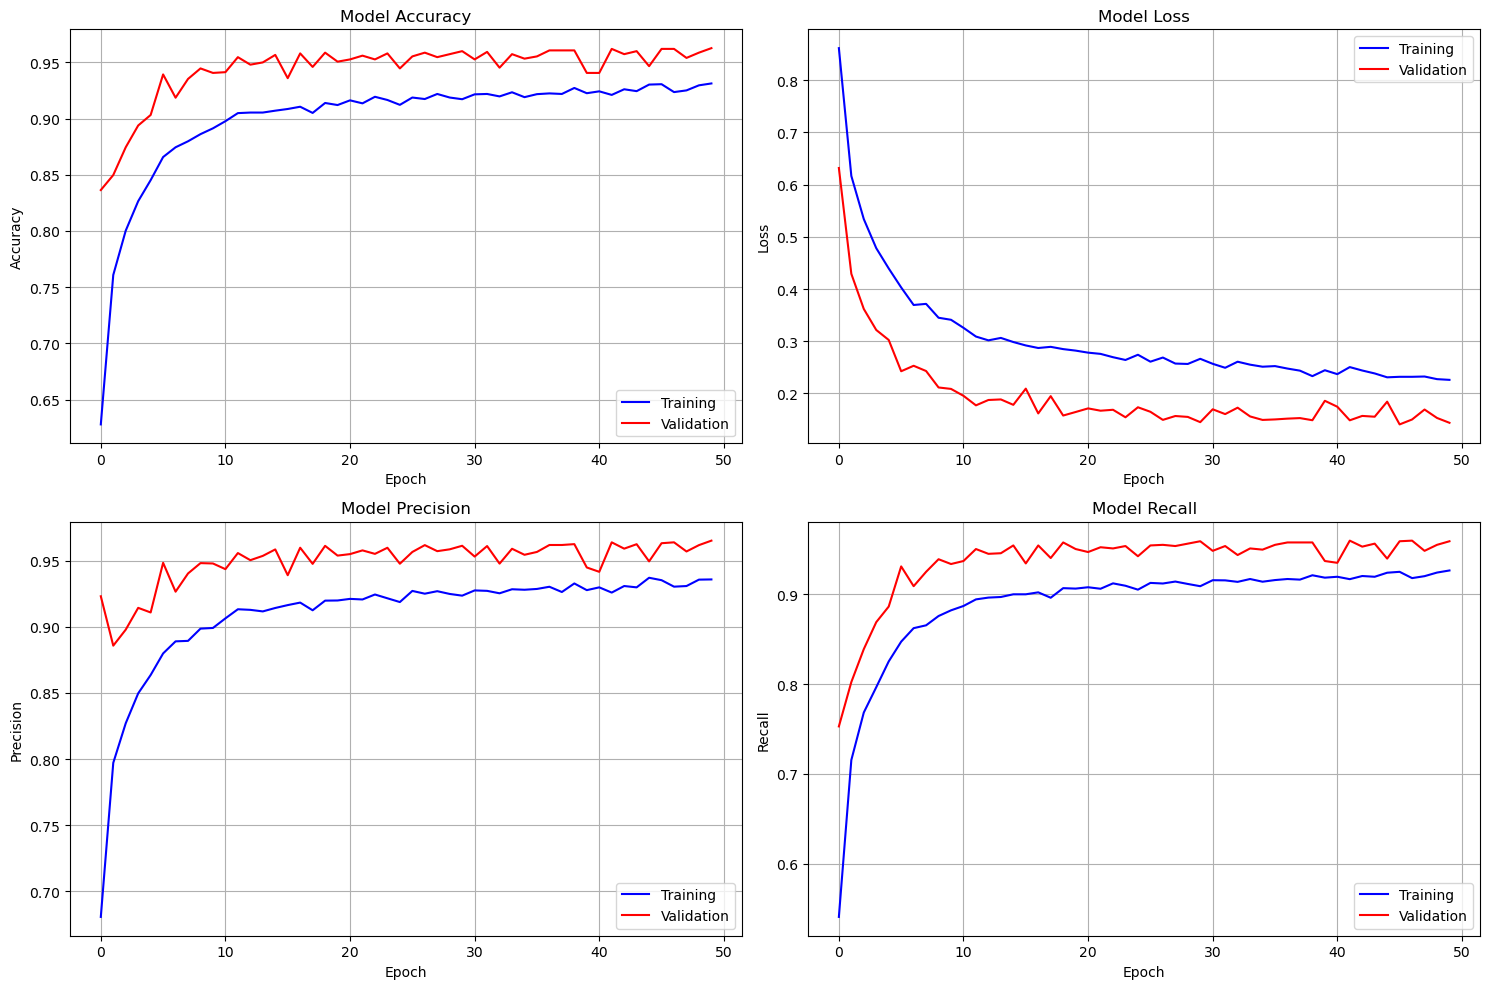

Final Test Accuracy: 0.9578


In [46]:
# Model Evaluation with Visualizations
# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Training History Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', color='red')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation', color='red')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training', color='blue')
axes[1, 0].plot(history.history['val_precision'], label='Validation', color='red')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training', color='blue')
axes[1, 1].plot(history.history['val_recall'], label='Validation', color='red')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accuracy:.4f}")


In [47]:
# View Selected Features
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [feature_columns[i] for i in selected_feature_indices]
feature_scores = selector.scores_[selected_feature_indices]

# Create a dataframe for better visualization
feature_info = pd.DataFrame({
    'Feature_Name': selected_feature_names,
    'F_Score': feature_scores,
    'Rank': range(1, len(selected_feature_names) + 1)
}).sort_values('F_Score', ascending=False)

print(f"Top {len(selected_feature_names)} Selected Features (ranked by F-score):")
print("=" * 60)
for i, row in feature_info.iterrows():
    print(f"{row['Rank']:2d}. {row['Feature_Name']:<40} (F-score: {row['F_Score']:.2f})")

print(f"\nTotal selected features: {len(selected_feature_names)}")
print(f"Feature reduction: {len(feature_columns)} → {len(selected_feature_names)} ({100*(1-len(selected_feature_names)/len(feature_columns)):.1f}% reduction)")


Top 5 Selected Features (ranked by F-score):
 3. y_coordinate                             (F-score: 685.71)
 1. heart_rate                               (F-score: 89.28)
 4. pupil_diameter_mm                        (F-score: 57.36)
 5. pupil_iris_ratio                         (F-score: 57.36)
 2. x_coordinate                             (F-score: 51.72)

Total selected features: 5
Feature reduction: 6 → 5 (16.7% reduction)


In [42]:
# Comprehensive Model Performance Metrics (Replicating the Classification Report)
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

def calculate_comprehensive_metrics(model, X_train, y_train, X_val, y_val, label_encoder):
    """
    Calculate comprehensive metrics for both training and validation sets
    similar to the classification report shown in the image
    """
    
    # Get predictions for training set
    y_train_pred = model.predict(X_train, verbose=0)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train, axis=1)
    
    # Get predictions for validation set  
    y_val_pred = model.predict(X_val, verbose=0)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    
    # Calculate metrics for each set
    train_precision, train_recall, train_f1, train_support = precision_recall_fscore_support(
        y_train_true_classes, y_train_pred_classes, average=None, zero_division=0
    )
    
    val_precision, val_recall, val_f1, val_support = precision_recall_fscore_support(
        y_val_true_classes, y_val_pred_classes, average=None, zero_division=0
    )
    
    # Calculate overall metrics
    train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
    val_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    
    # Macro averages
    train_macro_precision = np.mean(train_precision)
    train_macro_recall = np.mean(train_recall)
    train_macro_f1 = np.mean(train_f1)
    
    val_macro_precision = np.mean(val_precision)
    val_macro_recall = np.mean(val_recall)
    val_macro_f1 = np.mean(val_f1)
    
    # Weighted averages
    train_weighted_precision = np.average(train_precision, weights=train_support)
    train_weighted_recall = np.average(train_recall, weights=train_support)
    train_weighted_f1 = np.average(train_f1, weights=train_support)
    
    val_weighted_precision = np.average(val_precision, weights=val_support)
    val_weighted_recall = np.average(val_recall, weights=val_support)
    val_weighted_f1 = np.average(val_f1, weights=val_support)
    
    return {
        'train': {
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'support': train_support,
            'accuracy': train_accuracy,
            'macro_precision': train_macro_precision,
            'macro_recall': train_macro_recall,
            'macro_f1': train_macro_f1,
            'weighted_precision': train_weighted_precision,
            'weighted_recall': train_weighted_recall,
            'weighted_f1': train_weighted_f1
        },
        'val': {
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'support': val_support,
            'accuracy': val_accuracy,
            'macro_precision': val_macro_precision,
            'macro_recall': val_macro_recall,
            'macro_f1': val_macro_f1,
            'weighted_precision': val_weighted_precision,
            'weighted_recall': val_weighted_recall,
            'weighted_f1': val_weighted_f1
        }
    }

def print_classification_report_style(metrics, label_encoder):
    """
    Print metrics without support column (support still used internally for weighted calculations)
    """
    class_names = label_encoder.classes_
    
    print("Training performance:")
    print(f"{'':>12} {'precision':>10} {'recall':>10} {'f1-score':>10}")
    print()
    
    # Per-class metrics for training
    for i, class_name in enumerate(class_names):
        precision = metrics['train']['precision'][i]
        recall = metrics['train']['recall'][i] 
        f1 = metrics['train']['f1'][i]
        
        print(f"{class_name:>12} {precision:>10.2f} {recall:>10.2f} {f1:>10.2f}")
    
    print()
    print(f"{'accuracy':>12} {'':<21} {metrics['train']['accuracy']:>10.2f}")
    print(f"{'macro avg':>12} {metrics['train']['macro_precision']:>10.2f} {metrics['train']['macro_recall']:>10.2f} {metrics['train']['macro_f1']:>10.2f}")
    print(f"{'weighted avg':>12} {metrics['train']['weighted_precision']:>10.2f} {metrics['train']['weighted_recall']:>10.2f} {metrics['train']['weighted_f1']:>10.2f}")
    
    print()
    print("Validation performance:")
    print(f"{'':>12} {'precision':>10} {'recall':>10} {'f1-score':>10}")
    print()
    
    # Per-class metrics for validation
    for i, class_name in enumerate(class_names):
        precision = metrics['val']['precision'][i]
        recall = metrics['val']['recall'][i]
        f1 = metrics['val']['f1'][i]
        
        print(f"{class_name:>12} {precision:>10.2f} {recall:>10.2f} {f1:>10.2f}")
    
    print()
    print(f"{'accuracy':>12} {'':<21} {metrics['val']['accuracy']:>10.2f}")
    print(f"{'macro avg':>12} {metrics['val']['macro_precision']:>10.2f} {metrics['val']['macro_recall']:>10.2f} {metrics['val']['macro_f1']:>10.2f}")
    print(f"{'weighted avg':>12} {metrics['val']['weighted_precision']:>10.2f} {metrics['val']['weighted_recall']:>10.2f} {metrics['val']['weighted_f1']:>10.2f}")
    
    print()
    print(f"=== Avg Macro F1: {(metrics['train']['macro_f1'] + metrics['val']['macro_f1']) / 2:.3f} ===")

# We need to recreate the validation split used during training to get the exact same data
# Since we used validation_split=0.2, we need to split the training data the same way
train_size = int(0.8 * len(X_train_scaled))
X_train_subset = X_train_scaled[:train_size]
y_train_subset = y_train[:train_size]
X_val_subset = X_train_scaled[train_size:]
y_val_subset = y_train[train_size:]

print(f"Training subset: {X_train_subset.shape}")
print(f"Validation subset: {X_val_subset.shape}")
print()

# Calculate comprehensive metrics
metrics = calculate_comprehensive_metrics(
    model, X_train_subset, y_train_subset, X_val_subset, y_val_subset, label_encoder
)

# Print the classification report in the same style as the image
print_classification_report_style(metrics, label_encoder)


Training subset: (5987, 5)
Validation subset: (1497, 5)

Training performance:
              precision     recall   f1-score

      comedy       0.95       0.96       0.95
 documentary       0.97       0.97       0.97
      horror       0.96       0.96       0.96

    accuracy                             0.96
   macro avg       0.96       0.96       0.96
weighted avg       0.96       0.96       0.96

Validation performance:
              precision     recall   f1-score

      comedy       0.95       0.96       0.95
 documentary       0.99       0.97       0.98
      horror       0.95       0.96       0.95

    accuracy                             0.96
   macro avg       0.96       0.96       0.96
weighted avg       0.96       0.96       0.96

=== Avg Macro F1: 0.962 ===


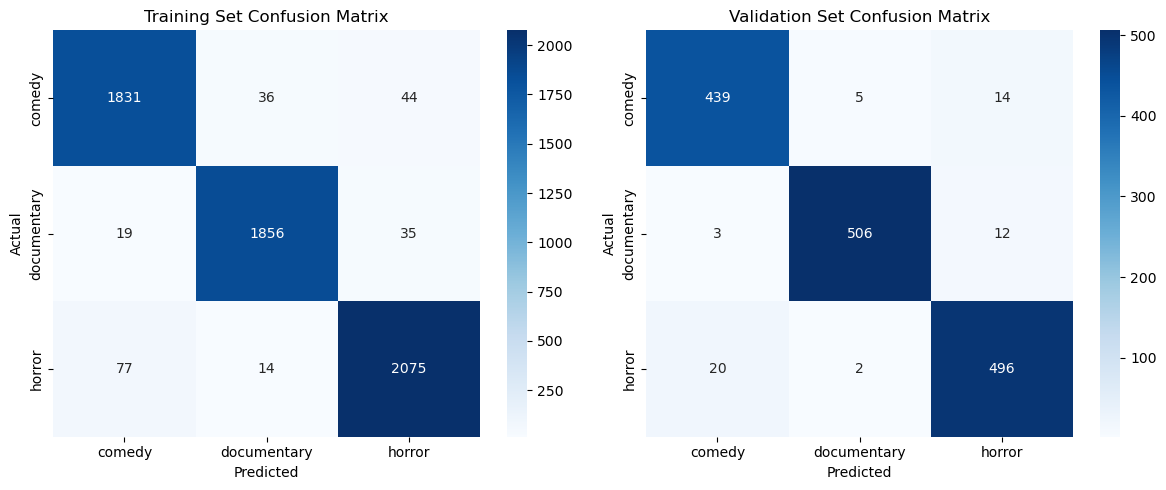

=== PER-CLASS PERFORMANCE ANALYSIS ===

Training vs Validation F1-Score Comparison:
--------------------------------------------------
comedy      : Train F1=0.954, Val F1=0.954, Diff=-0.000
documentary : Train F1=0.973, Val F1=0.979, Diff=-0.006
horror      : Train F1=0.961, Val F1=0.954, Diff=+0.007

Performance Summary:
--------------------
Best performing class (validation): documentary
Worst performing class (validation): horror
Most balanced class (precision-recall): horror


In [43]:
# Additional Performance Analysis
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(model, X_train, y_train, X_val, y_val, label_encoder):
    """
    Plot confusion matrices for both training and validation sets
    """
    # Get predictions
    y_train_pred = model.predict(X_train, verbose=0)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train, axis=1)
    
    y_val_pred = model.predict(X_val, verbose=0)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    
    # Create confusion matrices
    train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    val_cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Training confusion matrix
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[0])
    axes[0].set_title('Training Set Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Validation confusion matrix
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[1])
    axes[1].set_title('Validation Set Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return train_cm, val_cm

def analyze_class_performance(metrics, label_encoder):
    """
    Analyze performance for each class (without support counts)
    """
    print("=== PER-CLASS PERFORMANCE ANALYSIS ===")
    print()
    
    class_names = label_encoder.classes_
    
    print("Training vs Validation F1-Score Comparison:")
    print("-" * 50)
    for i, class_name in enumerate(class_names):
        train_f1 = metrics['train']['f1'][i]
        val_f1 = metrics['val']['f1'][i]
        difference = train_f1 - val_f1
        
        print(f"{class_name:<12}: Train F1={train_f1:.3f}, Val F1={val_f1:.3f}, Diff={difference:+.3f}")
        
        if difference > 0.2:
            print(f"             ⚠️  High overfitting for {class_name}")
        elif difference < -0.1:
            print(f"             ⚠️  Validation performs better - possible data issue")
    
    print()
    print("Performance Summary:")
    print("-" * 20)
    print(f"Best performing class (validation): {class_names[np.argmax(metrics['val']['f1'])]}")
    print(f"Worst performing class (validation): {class_names[np.argmin(metrics['val']['f1'])]}")
    print(f"Most balanced class (precision-recall): {class_names[np.argmin(np.abs(metrics['val']['precision'] - metrics['val']['recall']))]}")

# Generate confusion matrices
train_cm, val_cm = plot_confusion_matrices(
    model, X_train_subset, y_train_subset, X_val_subset, y_val_subset, label_encoder
)

# Analyze class performance
analyze_class_performance(metrics, label_encoder)


In [36]:
# Comprehensive Hyperparameter Tuning
from sklearn.model_selection import StratifiedKFold
from itertools import product
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_model(n_features, hidden_layers, dropout_rate, l2_reg, learning_rate):
    """
    Create a neural network model with specified hyperparameters
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_layers[0], input_dim=n_features, kernel_regularizer=l1_l2(l2=l2_reg)))
    model.add(LeakyReLU(alpha=0.0001))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, kernel_regularizer=l1_l2(l2=l2_reg)))
        model.add(LeakyReLU(alpha=0.0001))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def evaluate_hyperparameters(X, y, n_features, hidden_layers, dropout_rate, l2_reg, 
                           learning_rate, batch_size, cv_folds=3):
    """
    Evaluate a set of hyperparameters using cross-validation
    """
    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_selected = selector.fit_transform(X, np.argmax(y, axis=1))
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in kfold.split(X_scaled, np.argmax(y, axis=1)):
        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create and train model
        model = create_model(n_features, hidden_layers, dropout_rate, l2_reg, learning_rate)
        
        # Early stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Train model (reduced epochs for faster tuning)
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=30,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stop]
        )
        
        # Get best validation accuracy
        best_val_acc = max(history.history['val_accuracy'])
        cv_scores.append(best_val_acc)
        
        # Clean up to save memory
        del model
        tf.keras.backend.clear_session()
    
    return np.mean(cv_scores), np.std(cv_scores)

# Define hyperparameter search space
param_grid = {
    'n_features': [2, 3, 4, 5],  # Number of features to select
    'hidden_layers': [
        [16],           # Single layer
        [32],           # Single layer (larger)
        [32, 16],       # Two layers (current architecture)
        [64, 32],       # Two layers (larger)
        [32, 16, 8],    # Three layers
    ],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'l2_reg': [1e-4, 1e-3, 1e-2],
    'learning_rate': [0.0005, 0.001, 0.002],
    'batch_size': [16, 24, 32]
}

print("Starting Hyperparameter Tuning...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take a while...\n")

# Store results
results = []
best_score = 0
best_params = None

# Counter for progress tracking
total_combinations = np.prod([len(v) for v in param_grid.values()])
current_combination = 0

start_time = time.time()

# Grid search (using a subset for faster execution)
# We'll sample random combinations instead of full grid search for efficiency
np.random.seed(42)
n_random_search = min(50, total_combinations)  # Test up to 50 combinations

print(f"Using randomized search with {n_random_search} combinations for efficiency\n")

for i in range(n_random_search):
    # Randomly sample hyperparameters
    params = {
        'n_features': np.random.choice(param_grid['n_features']),
        'hidden_layers': param_grid['hidden_layers'][np.random.choice(len(param_grid['hidden_layers']))],
        'dropout_rate': np.random.choice(param_grid['dropout_rate']),
        'l2_reg': np.random.choice(param_grid['l2_reg']),
        'learning_rate': np.random.choice(param_grid['learning_rate']),
        'batch_size': np.random.choice(param_grid['batch_size'])
    }
    
    try:
        # Evaluate hyperparameters
        mean_score, std_score = evaluate_hyperparameters(
            X_train, y_train, **params
        )
        
        # Store results
        result = {
            **params,
            'mean_cv_score': mean_score,
            'std_cv_score': std_score
        }
        results.append(result)
        
        # Update best parameters
        if mean_score > best_score:
            best_score = mean_score
            best_params = params.copy()
        
        # Progress update
        current_combination += 1
        elapsed_time = time.time() - start_time
        avg_time_per_combination = elapsed_time / current_combination
        estimated_remaining = avg_time_per_combination * (n_random_search - current_combination)
        
        print(f"Combination {current_combination}/{n_random_search}: "
              f"Score = {mean_score:.4f} ± {std_score:.4f} "
              f"(ETA: {estimated_remaining/60:.1f} min)")
        
    except Exception as e:
        print(f"Error with combination {current_combination}: {e}")
        continue

print(f"\nHyperparameter tuning completed in {(time.time() - start_time)/60:.1f} minutes")

Starting Hyperparameter Tuning...
Total combinations to test: 2160
This may take a while...

Using randomized search with 50 combinations for efficiency


Combination 1/50: Score = 0.8133 ± 0.0053 (ETA: 27.8 min)
Combination 2/50: Score = 0.7488 ± 0.0041 (ETA: 20.2 min)
Combination 3/50: Score = 0.9161 ± 0.0033 (ETA: 23.1 min)
Combination 4/50: Score = 0.8197 ± 0.0044 (ETA: 23.3 min)
Combination 5/50: Score = 0.7786 ± 0.0035 (ETA: 23.2 min)
Combination 6/50: Score = 0.7624 ± 0.0094 (ETA: 21.5 min)
Combination 7/50: Score = 0.7699 ± 0.0042 (ETA: 20.2 min)
Combination 8/50: Score = 0.7535 ± 0.0045 (ETA: 19.1 min)
Combination 9/50: Score = 0.8270 ± 0.0107 (ETA: 18.5 min)
Combination 10/50: Score = 0.7535 ± 0.0049 (ETA: 17.4 min)
Combination 11/50: Score = 0.9110 ± 0.0041 (ETA: 17.2 min)
Combination 12/50: Score = 0.7871 ± 0.0053 (ETA: 16.7 min)
Combination 13/50: Score = 0.7441 ± 0.0147 (ETA: 15.9 min)
Combination 14/50: Score = 0.7608 ± 0.0084 (ETA: 15.2 min)
Combination 15/50: Score = 0

In [37]:
# Analyze and Display Hyperparameter Tuning Results
import pandas as pd

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

print("=== HYPERPARAMETER TUNING RESULTS ===\n")

# Display best parameters
print("🏆 BEST HYPERPARAMETERS:")
print(f"Cross-validation Score: {best_score:.4f}")
print("-" * 40)
for param, value in best_params.items():
    print(f"{param:<15}: {value}")

print(f"\n📊 PERFORMANCE COMPARISON:")
print("-" * 50)

# Sort results by score
results_df_sorted = results_df.sort_values('mean_cv_score', ascending=False)

# Display top 10 configurations
print("Top 10 Configurations:")
print(f"{'Rank':<4} {'Score':<8} {'Features':<8} {'Architecture':<15} {'Dropout':<8} {'L2 Reg':<8} {'LR':<8} {'Batch':<6}")
print("-" * 80)

for i, (idx, row) in enumerate(results_df_sorted.head(10).iterrows()):
    arch_str = str(row['hidden_layers']).replace(' ', '')
    print(f"{i+1:<4} {row['mean_cv_score']:.4f}   {row['n_features']:<8} {arch_str:<15} {row['dropout_rate']:<8.1f} {row['l2_reg']:<8.0e} {row['learning_rate']:<8.4f} {row['batch_size']:<6}")

# Analysis of hyperparameter importance
print(f"\n🔍 HYPERPARAMETER ANALYSIS:")
print("-" * 40)

# Feature count analysis
feature_analysis = results_df.groupby('n_features')['mean_cv_score'].agg(['mean', 'std', 'count'])
print("Features Impact:")
for n_features, stats in feature_analysis.iterrows():
    print(f"  {n_features} features: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")

# Architecture analysis
print("\nArchitecture Impact:")
arch_analysis = results_df.groupby(results_df['hidden_layers'].astype(str))['mean_cv_score'].agg(['mean', 'std', 'count'])
for arch, stats in arch_analysis.iterrows():
    print(f"  {arch}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")

# Dropout analysis
print("\nDropout Rate Impact:")
dropout_analysis = results_df.groupby('dropout_rate')['mean_cv_score'].agg(['mean', 'std', 'count'])
for dropout, stats in dropout_analysis.iterrows():
    print(f"  {dropout}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")

# Learning rate analysis
print("\nLearning Rate Impact:")
lr_analysis = results_df.groupby('learning_rate')['mean_cv_score'].agg(['mean', 'std', 'count'])
for lr, stats in lr_analysis.iterrows():
    print(f"  {lr}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")

print(f"\n💡 RECOMMENDATIONS:")
print("-" * 30)
print(f"• Best number of features: {best_params['n_features']}")
print(f"• Best architecture: {best_params['hidden_layers']}")
print(f"• Best dropout rate: {best_params['dropout_rate']}")
print(f"• Best L2 regularization: {best_params['l2_reg']:.0e}")
print(f"• Best learning rate: {best_params['learning_rate']}")
print(f"• Best batch size: {best_params['batch_size']}")

# Performance improvement
baseline_score = 0.79  # Approximate score from your current model
if best_score > baseline_score:
    improvement = ((best_score - baseline_score) / baseline_score) * 100
    print(f"\n🚀 Potential improvement: +{improvement:.1f}% over baseline ({baseline_score:.3f} → {best_score:.3f})")
else:
    print(f"\n📝 Note: Best score ({best_score:.3f}) is similar to current performance")

print(f"\n✅ Ready to implement optimized model with best hyperparameters!")


=== HYPERPARAMETER TUNING RESULTS ===

🏆 BEST HYPERPARAMETERS:
Cross-validation Score: 0.9500
----------------------------------------
n_features     : 5
hidden_layers  : [64, 32]
dropout_rate   : 0.2
l2_reg         : 0.001
learning_rate  : 0.0005
batch_size     : 16

📊 PERFORMANCE COMPARISON:
--------------------------------------------------
Top 10 Configurations:
Rank Score    Features Architecture    Dropout  L2 Reg   LR       Batch 
--------------------------------------------------------------------------------
1    0.9500   5        [64,32]         0.2      1e-03    0.0005   16    
2    0.9459   5        [32,16]         0.2      1e-03    0.0005   16    
3    0.9377   5        [32,16,8]       0.2      1e-02    0.0020   24    
4    0.9284   5        [32]            0.3      1e-03    0.0020   32    
5    0.9232   5        [32,16]         0.4      1e-03    0.0010   24    
6    0.9201   5        [32]            0.5      1e-04    0.0020   16    
7    0.9164   5        [16]            